In [1]:
!nvidia-smi

Mon Oct 30 19:03:27 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.92                 Driver Version: 545.92       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   41C    P0              26W / 130W |      0MiB /  6144MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import tensorflow as tf

# Check TensorFlow version
print(tf.__version__)

# Check available GPUs
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.14.0
Num GPUs Available:  0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/ham.zip
!unzip /content/drive/MyDrive/ham10000.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

In [3]:
import pandas as pd
import tensorflow
import numpy as np
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.applications import MobileNetV2

In [4]:
base_model=MobileNetV2(include_top=False, weights="imagenet", input_shape=(224,224,3))

In [5]:
model = Sequential()
model.add(base_model)
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.40))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(7, activation='softmax'))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(base_model)
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.20))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.20))
model.add(Dense(7, activation='softmax'))  # Using unique y values to determine the number of output classes

In [5]:
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization

model = Sequential()
model.add(base_model)
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))  # increased dropout
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))  # reduced size
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(7, activation='softmax'))

In [6]:
data=pd.read_csv("HAM10000_metadata.csv")
data['image_id_name']=data['image_id']+'.jpg'
X=data[['image_id_name','dx','lesion_id']]

In [7]:
X.sample(5)

,image_id_name,dx,lesion_id
9272,ISIC_0030229.jpg,nv,HAM_0003579
3416,ISIC_0024512.jpg,nv,HAM_0000539
4546,ISIC_0032276.jpg,nv,HAM_0005174
6764,ISIC_0028971.jpg,nv,HAM_0000930
343,ISIC_0027649.jpg,bkl,HAM_0006987


In [8]:
from sklearn.model_selection import train_test_split
Y=X.pop('dx').to_frame()
X_train, X_test, y_train, y_test   = train_test_split(X,Y, test_size=0.17, random_state=42)
X_train,X_val,y_train,y_val        =train_test_split(X_train, y_train, test_size=0.17, random_state=42)

In [9]:
train=pd.concat([X_train,y_train],axis=1)
val=pd.concat([X_val,y_val],axis=1)
test=pd.concat([X_test,y_test],axis=1)

In [10]:
print("Training set size:", train.shape[0])
print("Validation set size:", val.shape[0])
print("Test set size:", test.shape[0])

Training set size: 6898
Validation set size: 1414
Test set size: 1703


In [11]:
from sklearn.preprocessing import LabelEncoder
encoder= LabelEncoder()
encoder.fit(val['dx'])
name_as_indexes_train=encoder.transform(val['dx'])
val['label']=name_as_indexes_train

In [12]:
encoder=LabelEncoder()
encoder.fit(test['dx'])
name_as_indexes_test=encoder.transform(test['dx'])
test['label']=name_as_indexes_test

In [13]:
!pip install keras-preprocessing

In [14]:
from keras_preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(rescale = 1./255,rotation_range=10,
                                     zoom_range = 0.1,
                                     width_shift_range=0.0,  height_shift_range=0.00)
test_generator=ImageDataGenerator(rescale = 1./255,rotation_range=10,
                                     zoom_range = 0.1,
                                     width_shift_range=0.0,  height_shift_range=0.00)

In [15]:
train_data= train_generator.flow_from_dataframe(dataframe=train,x_col="image_id_name",y_col="dx",
                                                batch_size=32,directory="ham10000/",
                                                shuffle=True,class_mode="categorical",target_size=(224,224))

Found 6898 validated image filenames belonging to 7 classes.


In [16]:
test_data= test_generator.flow_from_dataframe(dataframe=test,x_col="image_id_name",y_col="dx",
                                              directory="ham10000/",
                                              shuffle=False,batch_size=1,class_mode=None,target_size=(224,224))

Found 1703 validated image filenames.


In [17]:
val_data=test_generator.flow_from_dataframe(dataframe=val,x_col="image_id_name",y_col="dx",
                                            directory="ham10000/",
                                            batch_size=64,shuffle=False,class_mode="categorical",target_size=(224,224))

Found 1414 validated image filenames belonging to 7 classes.


In [ ]:
from keras_preprocessing.image import ImageDataGenerator

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.0,
    height_shift_range=0.00
)

# Only rescaling for validation and test sets
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_data = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col="image_id_name",
    y_col="dx",
    batch_size=32,
    directory="/content/drive/MyDrive/ASM-SKIN/ham10000",
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224)
)

Found 6898 validated image filenames belonging to 7 classes.


In [ ]:
val_data = val_test_datagen.flow_from_dataframe(
    dataframe=val,
    x_col="image_id_name",
    y_col="dx",
    batch_size=64,
    directory="/content/drive/MyDrive/ASM-SKIN/ham10000",
    shuffle=False,  # Change to False if you have specific reasons to keep order
    class_mode="categorical",
    target_size=(224,224)
)

Found 1414 validated image filenames belonging to 7 classes.


In [ ]:
test_data = val_test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col="image_id_name",
    y_col="dx",
    directory="/content/drive/MyDrive/ASM-SKIN/ham10000",
    shuffle=False,
    batch_size=64,  # You can change to 1 if you have specific reasons
    class_mode=None,
    target_size=(224,224)
)

Found 1703 validated image filenames.


In [18]:
# Imports
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD

# Define the optimizer
sgd = SGD(learning_rate=0.01, clipvalue=0.5)

# Compile the model
model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["accuracy"])

# Define the learning rate reduction callback
learning_control = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.0001
)

In [19]:
# Fit the model
history = model.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size,
    epochs=30,
    verbose=1,
    callbacks=[learning_control]
)

Epoch 1/30
 90/215 [===========>..................] - ETA: 26:19 - loss: 1.2952 - accuracy: 0.6326

KeyboardInterrupt: ignored

In [21]:
from keras.callbacks import ReduceLROnPlateau
learning_control = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=.5, min_lr=0.0001)

In [ ]:
from keras.optimizers import Adam, SGD

sgd = SGD(learning_rate=0.01, clipvalue=0.5)
model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["accuracy"])

In [22]:
from keras.optimizers import Adam

# Initialize the Adam optimizer with the desired learning rate and clip value
adam = Adam()

# Compile the model with the Adam optimizer
model.compile(optimizer=adam, loss="categorical_crossentropy", metrics=["accuracy"])

In [23]:
history = model.fit_generator(generator=train_data,
                            steps_per_epoch=train_data.samples//train_data.batch_size,
                            validation_data=val_data,
                            verbose=1,
                            validation_steps=val_data.samples//val_data.batch_size,
                            epochs=30,callbacks=[learning_control])

C:\Users\dcent\AppData\Local\Temp\ipykernel_16656\1443149548.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_data,


Epoch 1/30
215/215 [==============================] - 563s 3s/step - loss: 0.7418 - accuracy: 0.7234 - val_loss: 2.7467 - val_accuracy: 0.6612 - lr: 0.0010
Epoch 2/30
215/215 [==============================] - 516s 2s/step - loss: 0.7206 - accuracy: 0.7307 - val_loss: 3.0568 - val_accuracy: 0.6726 - lr: 0.0010
Epoch 3/30
215/215 [==============================] - 467s 2s/step - loss: 0.6956 - accuracy: 0.7418 - val_loss: 2.0468 - val_accuracy: 0.6456 - lr: 0.0010
Epoch 4/30
215/215 [==============================] - 466s 2s/step - loss: 0.6802 - accuracy: 0.7454 - val_loss: 1.3475 - val_accuracy: 0.6520 - lr: 0.0010
Epoch 5/30
215/215 [==============================] - ETA: 0s - loss: 0.6607 - accuracy: 0.7559
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
215/215 [==============================] - 467s 2s/step - loss: 0.6607 - accuracy: 0.7559 - val_loss: 1.5470 - val_accuracy: 0.6435 - lr: 0.0010
Epoch 6/30
215/215 [==============================] - 466s 

In [32]:
model.save('model_adam_1.h5')

D:\Anaconda\envs\tf_gpu_env\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


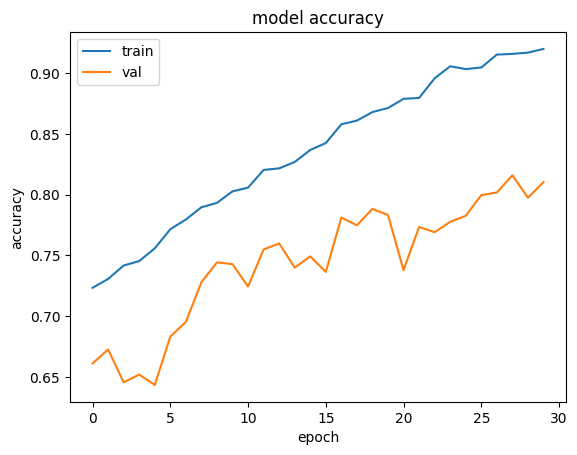

In [24]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

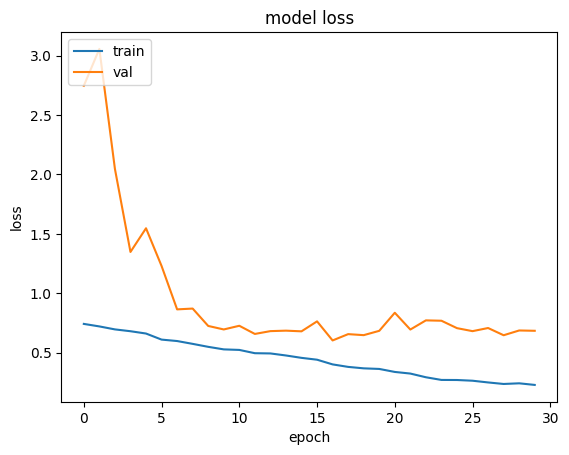

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

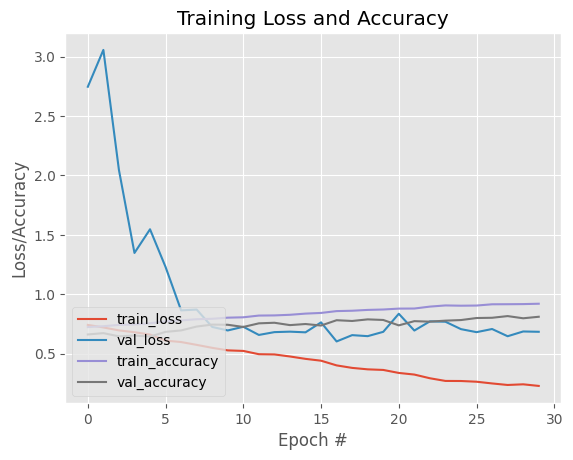

In [26]:
N = 30
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")


In [27]:
test_data.reset()
predictions = model.predict_generator(test_data, steps=test_data.samples/test_data.batch_size,verbose=1)
y_pred= np.argmax(predictions, axis=1)

C:\Users\dcent\AppData\Local\Temp\ipykernel_16656\1044357436.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_data, steps=test_data.samples/test_data.batch_size,verbose=1)


1703/1703 [==============================] - 38s 22ms/step


In [28]:
c=np.where(y_pred == name_as_indexes_test)

In [29]:
np.count_nonzero(c)

1347

In [30]:
print("Test Accuracy :",(np.count_nonzero(c)/len(name_as_indexes_test))*100)

Test Accuracy : 79.09571344685848


In [31]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(name_as_indexes_test, y_pred)

print(report)

              precision    recall  f1-score   support

           0       0.48      0.39      0.43        62
           1       0.59      0.56      0.57        77
           2       0.64      0.57      0.60       201
           3       0.23      0.12      0.16        24
           4       0.65      0.30      0.41       191
           5       0.85      0.96      0.90      1128
           6       0.94      0.85      0.89        20

    accuracy                           0.79      1703
   macro avg       0.63      0.54      0.57      1703
weighted avg       0.77      0.79      0.77      1703



In [33]:
model.save("model_adama.h5")